In [119]:
# once i have wholegenome_offset.trees
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
from matplotlib import colors as mcolors
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm 
from scipy.stats import skew

In [120]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 

In [121]:
heritability_data= {'1': 0.1,
'2': 0.3,
'3': 0.5,
'4': 0.7,
'5': 0.9}

optima_dict = {'optima7': 7,
               'optima6': 6,
               'optima5': 5,
               'optima4': 4,
               'optima3': 3,
               'optima2': 2,
               'optima1.5': 1.5,
               'optima1': 1,
               'optima0': 0}

def get_params(df):
    df = df.reset_index()
    df['index'] = df['index'].str.split('/subp').str[0]
    df['optima'] = df['index'].str.split('/').str[-1]
    df['sel'] = df['index'].str.split('/').str[-2]
    df['h2'] = df['index'].str.split('/').str[-3]
    df['poly'] = df['index'].str.split('_').str[-2]
    df['rep'] = df['index'].str.split('_').str[-1].str.split('/').str[0]
    df = df.drop('index',axis=1)
    return df

In [122]:
palette = sns.color_palette("viridis", 3)
h1_levels = [0.1, 0.5, 0.9]

In [123]:
path = '/global/scratch/users/tbellg/slim_grenenet_results/final_results_cteg_talk/scrapping_results/es_dep_af/'

In [124]:
path = '/home/tbellagio/simulations/slim_grenenet_results/final_results_cteg_talk/scrapping_results/es_dep_af/'

In [125]:
vfitnes = pd.read_csv(path + 'vfitnes.csv', index_col=[0])
vfitnes = get_params(vfitnes)

In [126]:
vfitnes['vfitnes_gen0'] = vfitnes['0']

In [127]:
vfitnes = vfitnes[['optima', 'sel', 'h2', 'poly', 'rep', 'vfitnes_gen0']]

In [128]:
vfitnes['poly'] = vfitnes['poly'].str.replace('pi', '').astype(int)
vfitnes.loc[:, 'h2'] = vfitnes['h2'].replace(heritability_data)

/tmp/ipykernel_432282/3340801138.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vfitnes.loc[:, 'h2'] = vfitnes['h2'].replace(heritability_data)


In [129]:
vfitnes['log_poly'] = np.log(vfitnes['poly'])

In [130]:
# delete optima 0 

vfitnes = vfitnes[vfitnes['optima'] != 'optima0' ]
vfitnes = vfitnes[vfitnes['optima'] != 'optima1.5' ]


In [131]:
vfitnes['optima_int'] = vfitnes['optima'].str.replace('optima', '').astype(int)

In [75]:
import pandas as pd
from scipy.stats import skew, ttest_ind, mannwhitneyu

low_poly = [1, 2, 5, 10, 20]
high_poly = [50, 100, 500, 1000]

results = []
all_skews = []  # to collect all per-poly skew values across optima

for opt in vfitnes['optima_int'].unique():
    df_opt = vfitnes[(vfitnes['h2'] == 0.9) & (vfitnes['optima_int'] == opt)]

    skew_by_poly = (
        df_opt
        .groupby('poly')['vfitnes_gen0']
        .apply(lambda x: skew(x, bias=False))
        .reset_index(name='skew')
    )
    skew_by_poly['optima_int'] = opt  # label with env change

    all_skews.append(skew_by_poly)  # store for later

    # Split into low and high groups
    low_skews = skew_by_poly[skew_by_poly['poly'].isin(low_poly)]['skew'].values
    high_skews = skew_by_poly[skew_by_poly['poly'].isin(high_poly)]['skew'].values

    # Run t-test or Mann-Whitney
    t_stat, t_pval = ttest_ind(low_skews, high_skews, equal_var=False)
    u_stat, u_pval = mannwhitneyu(low_skews, high_skews, alternative='two-sided')

    results.append({
        'optima_int': opt,
        'low_poly_skew_mean': low_skews.mean(),
        'high_poly_skew_mean': high_skews.mean(),
        't_pval': t_pval,
        'u_pval': u_pval,
        'n_low': len(low_skews),
        'n_high': len(high_skews)
    })

# Final DataFrames
results_df = pd.DataFrame(results)
all_skews_df = pd.concat(all_skews, ignore_index=True)


/carnegie/hpcdata/software/conda/envs/python-3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: invalid value encountered in divide
  nval = np.sqrt((n - 1.0) * n) / (n - 2.0) * m3 / m2**1.5


In [80]:
all_skews_df[all_skews_df['optima_int'] == 1]

,poly,skew,optima_int
27,1,5.203499,1
28,2,1.867447,1
29,5,0.056773,1
30,10,-0.772864,1
31,20,0.483666,1
32,50,0.094619,1
33,100,-0.705557,1
34,500,-0.320716,1
35,1000,0.272438,1


In [78]:
results_df['low_poly_skew_mean'] / results_df['high_poly_skew_mean'] 

0    2.409546
1    0.586352
2    2.040384
3   -8.298976
4         NaN
5    2.276965
6    0.653326
dtype: float64

In [77]:
results_df.sort_values('optima_int')

,optima_int,low_poly_skew_mean,high_poly_skew_mean,t_pval,u_pval,n_low,n_high
3,1,1.367704,-0.164804,0.220790,0.412698,5,4
0,2,1.212676,0.503280,0.175025,0.412698,5,4
5,3,1.384425,0.608013,0.089673,0.111111,5,4
2,4,2.300954,1.127706,0.091729,0.063492,5,4
6,5,2.997464,4.588010,0.036152,0.063492,5,4
1,6,6.743013,11.499930,0.068957,0.285714,5,4
4,7,NaN,12.247449,NaN,NaN,5,4


In [12]:
#vfitnes = vfitnes[vfitnes['vfitnes_gen0'] != 0]

In [132]:
vfitnes = vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].std() #/ np.sqrt(vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].size())

vfitnes = vfitnes.reset_index()

vfitnes['poly_str'] = vfitnes['poly'].astype(str)

vfitnes = vfitnes[vfitnes['optima']!= 'optima1.5']


vfitnes['optima_int'] = vfitnes['optima'].map(optima_dict)

In [133]:
vfitnes

,optima,sel,h2,poly,log_poly,vfitnes_gen0,poly_str,optima_int
0,optima1,estrongsel,0.1,1,0.000000,2.250841e-03,1,1.0
1,optima1,estrongsel,0.1,2,0.693147,2.417473e-03,2,1.0
2,optima1,estrongsel,0.1,5,1.609438,2.313377e-03,5,1.0
3,optima1,estrongsel,0.1,10,2.302585,2.384225e-03,10,1.0
4,optima1,estrongsel,0.1,20,2.995732,2.458509e-03,20,1.0
...,...,...,...,...,...,...,...,...
247,optima7,estrongsel,0.9,20,2.995732,1.113096e-130,20,7.0
248,optima7,estrongsel,0.9,50,3.912023,4.769108e-84,50,7.0
249,optima7,estrongsel,0.9,100,4.605170,1.025234e-93,100,7.0
250,optima7,estrongsel,0.9,500,6.214608,1.682669e-30,500,7.0


In [134]:
vfitnes = vfitnes[vfitnes['h2']==0.9]

In [135]:

# Define the independent variables and add a constant to the model (intercept)
X = vfitnes[['log_poly', 'h2', 'optima_int']]
X = sm.add_constant(X)  # adding a constant

# Define the dependent variable
y = vfitnes['vfitnes_gen0']

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the model to get the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           vfitnes_gen0   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     43.98
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           1.74e-12
Time:                        15:40:15   Log-Likelihood:                 281.22
No. Observations:                  63   AIC:                            -556.4
Df Residuals:                      60   BIC:                            -550.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
log_poly      -0.0007      0.000     -4.360      0.0

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Create a custom truncated grayscale palette (e.g., skip 0–0.3, only use darker grays)
def truncated_cmap(cmap_name='Greys', min_val=0.3, max_val=1.0, n=256):
    cmap = cm.get_cmap(cmap_name)
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'{cmap_name}_trunc',
        cmap(np.linspace(min_val, max_val, n))
    )
    return new_cmap

In [137]:
# Generate discrete colors for each unique `optima_int`
unique_vals = sorted(vfitnes['optima_int'].unique())
gray_palette = truncated_cmap('Greys', 0.3, 1.0)(np.linspace(0, 1, len(unique_vals)))
gray_colors = [mcolors.to_hex(c) for c in gray_palette]

# Map unique values to colors
color_dict = dict(zip(unique_vals, gray_colors))

/tmp/ipykernel_432282/178734860.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


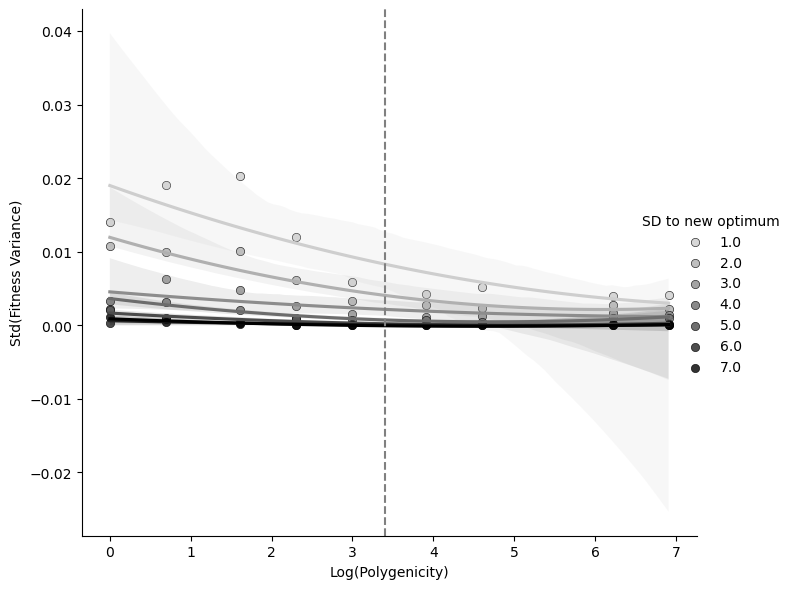

In [139]:
# Use lmplot and adjust the figure size
g = sns.lmplot(
    data=vfitnes,
    x='log_poly',
    y='vfitnes_gen0',
    scatter=True,
    order=2,
    hue="optima_int",
    palette=color_dict,
    height=6,
    aspect=1.2,
    scatter_kws={'edgecolor': 'black', 'linewidths': 0.5}  # <-- fixed this
)

# Calculate the x and y values for the line and text
x_value = np.log(30)

# Add a vertical line to the plot
plt.axvline(x=x_value, color='grey', linestyle='--')

# Change the labels of the x and y axes
g.set_xlabels('Log(Polygenicity)')
g.set_ylabels('Std(Fitness Variance)')

g._legend.set_title("SD to new optimum")

# Add a label for the vertical line
g.ax.text(x=x_value - 0.2,  # Adjust this value as needed to move the text to the left
         y=0.02, 
         s='log(30)', 
         horizontalalignment='right', 
         verticalalignment='top', 
         color='grey', 
         fontsize=16)

# Uncomment to save the figure
#g.savefig("figures/varvarfit_overpoly.pdf", bbox_inches='tight')
#g.savefig("figures/varvarfit_overpoly.png", format='png', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0']   # .mean() #/ np.sqrt(vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].size())

In [17]:
from scipy.stats import skew

vfitnes_skew = (
    vfitnes
    .groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0']
    .agg(lambda x: skew(x, bias=False))  # bias=False for unbiased skewness
    .reset_index(name='skewness')
)

/carnegie/hpcdata/software/conda/envs/python-3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: invalid value encountered in divide
  nval = np.sqrt((n - 1.0) * n) / (n - 2.0) * m3 / m2**1.5


In [253]:
vfitnes_mean = vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].std() #/ np.sqrt(vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].size())

vfitnes_mean = vfitnes_mean.reset_index()

vfitnes_mean['poly_str'] = vfitnes_mean['poly'].astype(str)

vfitnes_mean = vfitnes_mean[vfitnes_mean['optima']!= 'optima1.5']

vfitnes_mean['optima_int'] = vfitnes_mean['optima'].str.replace('optima', '').astype(int)

vfitnes_mean['optima_int'] = vfitnes_mean['optima'].map(optima_dict)

vfitnes1 = vfitnes_mean[vfitnes_mean['h2']==0.9]

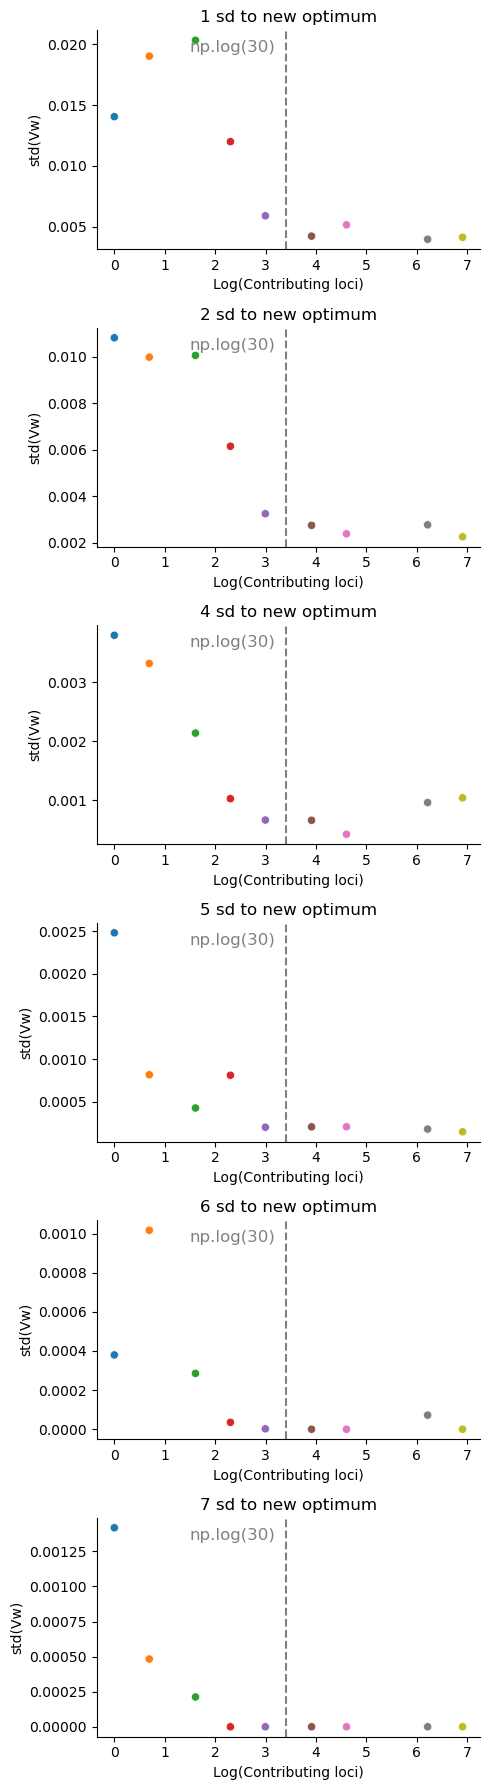

In [254]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming 'vfitnes' is your DataFrame and it contains an 'optima' column with multiple unique values
optima_values = ['optima1', 'optima2', 'optima4', 'optima5', 'optima6', 'optima7']

# Set up the subplotsx
n_optima = len(optima_values)
fig, axs = plt.subplots(n_optima, 1, figsize=(5, 3 * n_optima))  # Adjusting the subplot size

# Track handles and labels for the legend
handles, labels = None, None

for ax, optima in zip(axs, optima_values):
    # Filter the data for the current 'optima'
    vfitnes_h27 = vfitnes1[vfitnes1['optima'] == optima]
    
    # Create the scatter plot for the current 'optima'
    scatter = sns.scatterplot(data=vfitnes_h27, x='log_poly', y='vfitnes_gen0', hue='poly_str', ax=ax, legend=False)
    
    # Capture handles and labels for the first subplot to use for a figure-wide legend
    if handles is None and labels is None:
        handles, labels = scatter.get_legend_handles_labels()
    
    # Add a vertical line
    x_value = np.log(30)
    y_value = vfitnes_h27['vfitnes_gen0'].max()
    ax.axvline(x=x_value, color='grey', linestyle='--')
    
    # Change x and y axis labels and set title to indicate the 'optima'
    ax.set_xlabel('Log(Contributing loci)')
    ax.set_ylabel('std(Vw)')
    optima = optima.replace('optima', '')
    ax.set_title(f'{optima} sd to new optimum')
    
    # Add a label for the vertical line
    ax.text(x=x_value - 0.2, y=y_value, s='np.log(30)', horizontalalignment='right', verticalalignment='top', color='grey', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Place a single legend outside the subplots
#fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.25, 0.5), title='Poly String')
#plt.savefig("log_polyvs_sefitnessvar_sim.pdf", format='pdf', bbox_inches='tight')
plt.savefig("stdvw.png", format='png', bbox_inches='tight')

plt.tight_layout()
plt.show()

In [255]:
vfitnes_mean = vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].mean() #/ np.sqrt(vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].size())
vfitnes_std = vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].std() #/ np.sqrt(vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].size())




In [256]:
!pwd

/home/tbellagio/simulations/slim_grenenet_results/final_results_cteg_talk/final_results_es_dep_af


In [257]:
vfitnes_mean = vfitnes_mean.reset_index()
vfitnes_std = vfitnes_std.reset_index()

In [258]:
vfitnes_std[(vfitnes_std['poly'] > 50) & vfitnes_mean['optima'].isin(['optima6', 'optima7'])]

,optima,sel,h2,poly,log_poly,vfitnes_gen0
258,optima6,estrongsel,0.1,100,4.605170,1.045051e-03
259,optima6,estrongsel,0.1,500,6.214608,9.115805e-04
260,optima6,estrongsel,0.1,1000,6.907755,1.003914e-03
267,optima6,estrongsel,0.5,100,4.605170,1.020137e-04
268,optima6,estrongsel,0.5,500,6.214608,1.214139e-04
269,optima6,estrongsel,0.5,1000,6.907755,1.576976e-04
276,optima6,estrongsel,0.7,100,4.605170,3.522446e-05
277,optima6,estrongsel,0.7,500,6.214608,8.614184e-05
278,optima6,estrongsel,0.7,1000,6.907755,3.529795e-05
285,optima6,estrongsel,0.9,100,4.605170,5.665644e-09


In [259]:
vfitnes_mean[(vfitnes_mean['poly'] > 50) & vfitnes_mean['optima'].isin(['optima6', 'optima7'])]

,optima,sel,h2,poly,log_poly,vfitnes_gen0
258,optima6,estrongsel,0.1,100,4.605170,3.642351e-03
259,optima6,estrongsel,0.1,500,6.214608,3.552675e-03
260,optima6,estrongsel,0.1,1000,6.907755,3.721839e-03
267,optima6,estrongsel,0.5,100,4.605170,2.946737e-05
268,optima6,estrongsel,0.5,500,6.214608,6.074169e-05
269,optima6,estrongsel,0.5,1000,6.907755,8.884126e-05
276,optima6,estrongsel,0.7,100,4.605170,3.341153e-06
277,optima6,estrongsel,0.7,500,6.214608,2.217520e-05
278,optima6,estrongsel,0.7,1000,6.907755,6.421862e-06
285,optima6,estrongsel,0.9,100,4.605170,4.858250e-10


In [262]:
vfitnes_mean = vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].mean() #/ np.sqrt(vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].size())
vfitnes_std = vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].std() #/ np.sqrt(vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].size())

In [263]:
vfitnes_mean = vfitnes_std/vfitnes_mean
vfitnes_mean = vfitnes_mean.reset_index()

vfitnes_mean['poly_str'] = vfitnes_mean['poly'].astype(str)

vfitnes_mean = vfitnes_mean[vfitnes_mean['optima']!= 'optima1.5']

vfitnes_mean['optima_int'] = vfitnes_mean['optima'].str.replace('optima', '').astype(int)

vfitnes_mean['optima_int'] = vfitnes_mean['optima'].map(optima_dict)

vfitnes1 = vfitnes_mean[vfitnes_mean['h2']==0.9]

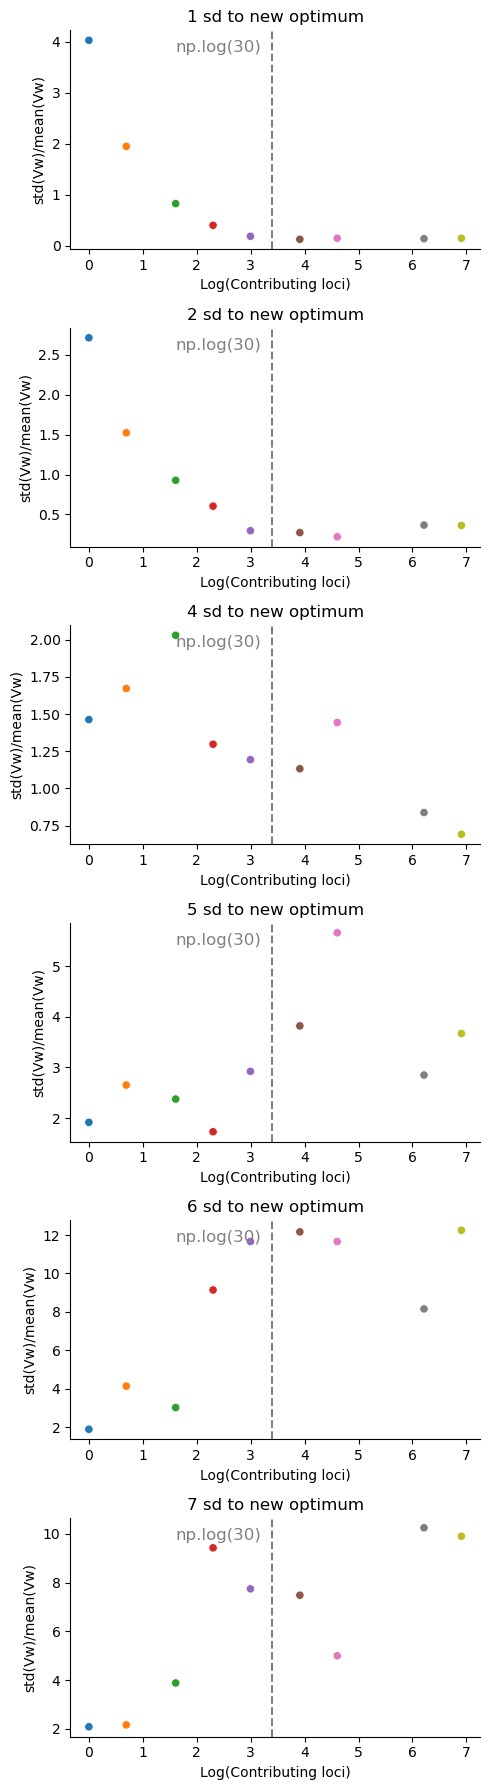

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming 'vfitnes' is your DataFrame and it contains an 'optima' column with multiple unique values
optima_values = ['optima1', 'optima2', 'optima4', 'optima5', 'optima6', 'optima7']

# Set up the subplotsx
n_optima = len(optima_values)
fig, axs = plt.subplots(n_optima, 1, figsize=(5, 3 * n_optima))  # Adjusting the subplot size

# Track handles and labels for the legend
handles, labels = None, None

for ax, optima in zip(axs, optima_values):
    # Filter the data for the current 'optima'
    vfitnes_h27 = vfitnes1[vfitnes1['optima'] == optima]
    
    # Create the scatter plot for the current 'optima'
    scatter = sns.scatterplot(data=vfitnes_h27, x='log_poly', y='vfitnes_gen0', hue='poly_str', ax=ax, legend=False)
    
    # Capture handles and labels for the first subplot to use for a figure-wide legend
    if handles is None and labels is None:
        handles, labels = scatter.get_legend_handles_labels()
    
    # Add a vertical line
    x_value = np.log(30)
    y_value = vfitnes_h27['vfitnes_gen0'].max()
    ax.axvline(x=x_value, color='grey', linestyle='--')
    
    # Change x and y axis labels and set title to indicate the 'optima'
    ax.set_xlabel('Log(Contributing loci)')
    ax.set_ylabel('std(Vw)/mean(Vw)')
    optima = optima.replace('optima', '')
    ax.set_title(f'{optima} sd to new optimum')
    
    # Add a label for the vertical line
    ax.text(x=x_value - 0.2, y=y_value, s='np.log(30)', horizontalalignment='right', verticalalignment='top', color='grey', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Place a single legend outside the subplots
#fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.25, 0.5), title='Poly String')
#plt.savefig("log_polyvs_sefitnessvar_sim.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("log_polyvs_sefitnessvar_sim.png", format='png', bbox_inches='tight')
plt.savefig("coefvarvw.png", format='png', bbox_inches='tight')

plt.tight_layout()
plt.show()

In [210]:
vfitnes_mean = vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].mean() / np.sqrt(vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].size())
#vfitnes_std = vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].std() #/ np.sqrt(vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].size())


#vfitnes_mean = vfitnes_std/vfitnes_mean
vfitnes_mean = vfitnes_mean.reset_index()

vfitnes_mean['poly_str'] = vfitnes_mean['poly'].astype(str)

vfitnes_mean = vfitnes_mean[vfitnes_mean['optima']!= 'optima1.5']

vfitnes_mean['optima_int'] = vfitnes_mean['optima'].str.replace('optima', '').astype(int)

vfitnes_mean['optima_int'] = vfitnes_mean['optima'].map(optima_dict)

vfitnes1 = vfitnes_mean[vfitnes_mean['h2']==0.9]

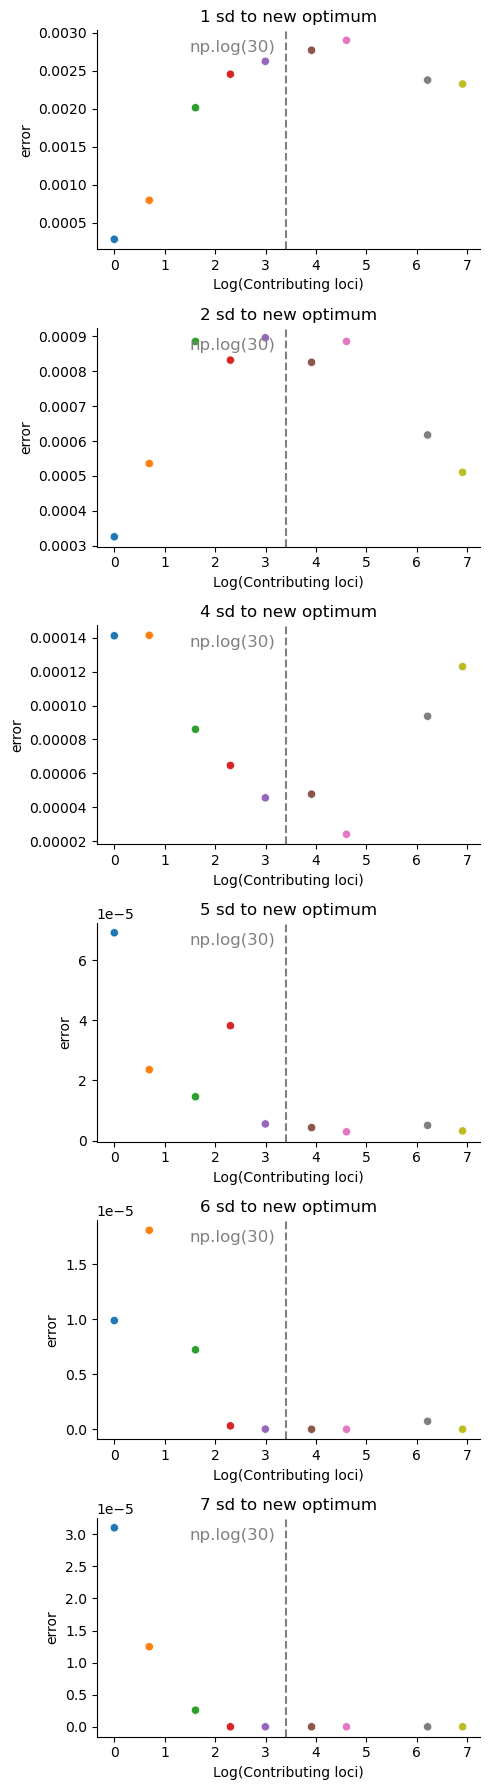

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming 'vfitnes' is your DataFrame and it contains an 'optima' column with multiple unique values
optima_values = ['optima1', 'optima2', 'optima4', 'optima5', 'optima6', 'optima7']

# Set up the subplotsx
n_optima = len(optima_values)
fig, axs = plt.subplots(n_optima, 1, figsize=(5, 3 * n_optima))  # Adjusting the subplot size

# Track handles and labels for the legend
handles, labels = None, None

for ax, optima in zip(axs, optima_values):
    # Filter the data for the current 'optima'
    vfitnes_h27 = vfitnes1[vfitnes1['optima'] == optima]
    
    # Create the scatter plot for the current 'optima'
    scatter = sns.scatterplot(data=vfitnes_h27, x='log_poly', y='vfitnes_gen0', hue='poly_str', ax=ax, legend=False)
    
    # Capture handles and labels for the first subplot to use for a figure-wide legend
    if handles is None and labels is None:
        handles, labels = scatter.get_legend_handles_labels()
    
    # Add a vertical line
    x_value = np.log(30)
    y_value = vfitnes_h27['vfitnes_gen0'].max()
    ax.axvline(x=x_value, color='grey', linestyle='--')
    
    # Change x and y axis labels and set title to indicate the 'optima'
    ax.set_xlabel('Log(Contributing loci)')
    ax.set_ylabel('error')
    optima = optima.replace('optima', '')
    ax.set_title(f'{optima} sd to new optimum')
    
    # Add a label for the vertical line
    ax.text(x=x_value - 0.2, y=y_value, s='np.log(30)', horizontalalignment='right', verticalalignment='top', color='grey', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Place a single legend outside the subplots
#fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.25, 0.5), title='Poly String')
#plt.savefig("log_polyvs_sefitnessvar_sim.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("log_polyvs_sefitnessvar_sim.png", format='png', bbox_inches='tight')
plt.savefig("error(vw).png", format='png', bbox_inches='tight')

plt.tight_layout()
plt.show()

In [ ]:
vfitnes_std = vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].std() #/ np.sqrt(vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].size())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming 'vfitnes' is your DataFrame and it contains an 'optima' column with multiple unique values
optima_values = ['optima1', 'optima2', 'optima4', 'optima5', 'optima6', 'optima7']

# Set up the subplots
n_optima = len(optima_values)
fig, axs = plt.subplots(n_optima, 1, figsize=(5, 3 * n_optima))  # Adjusting the subplot size

# Track handles and labels for the legend
handles, labels = None, None

for ax, optima in zip(axs, optima_values):
    # Filter the data for the current 'optima'
    vfitnes_h27 = vfitnes1[vfitnes1['optima'] == optima]
    
    # Create the scatter plot for the current 'optima'
    scatter = sns.scatterplot(data=vfitnes_h27, x='log_poly', y='vfitnes_gen0', hue='poly_str', ax=ax, legend=False)
    
    # Capture handles and labels for the first subplot to use for a figure-wide legend
    if handles is None and labels is None:
        handles, labels = scatter.get_legend_handles_labels()
    
    # Add a vertical line
    x_value = np.log(30)
    y_value = vfitnes_h27['vfitnes_gen0'].max()
    ax.axvline(x=x_value, color='grey', linestyle='--')
    
    # Change x and y axis labels and set title to indicate the 'optima'
    ax.set_xlabel('Log(Contributing loci)')
    ax.set_ylabel('Fitness Mean')
    optima = optima.replace('optima', '')
    ax.set_title(f'{optima} sd to new optimum')
    
    # Add a label for the vertical line
    ax.text(x=x_value - 0.2, y=y_value, s='np.log(30)', horizontalalignment='right', verticalalignment='top', color='grey', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Place a single legend outside the subplots
#fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.25, 0.5), title='Poly String')
#plt.savefig("log_polyvs_sefitnessvar_sim.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("log_polyvs_sefitnessvar_sim.png", format='png', bbox_inches='tight')

plt.tight_layout()
plt.show()

In [165]:
vfitnes

,optima,sel,h2,poly,log_poly,vfitnes_gen0,poly_str,optima_int
0,optima0,estrongsel,0.1,1,0.000000,2.197632e-02,1,0.0
1,optima0,estrongsel,0.1,2,0.693147,2.166149e-02,2,0.0
2,optima0,estrongsel,0.1,5,1.609438,2.125122e-02,5,0.0
3,optima0,estrongsel,0.1,10,2.302585,2.130541e-02,10,0.0
4,optima0,estrongsel,0.1,20,2.995732,2.117563e-02,20,0.0
...,...,...,...,...,...,...,...,...
319,optima7,estrongsel,0.9,20,2.995732,9.089665e-132,20,7.0
320,optima7,estrongsel,0.9,50,3.912023,3.893960e-85,50,7.0
321,optima7,estrongsel,0.9,100,4.605170,8.371013e-95,100,7.0
322,optima7,estrongsel,0.9,500,6.214608,1.373893e-31,500,7.0


In [138]:
vfitnes = vfitnes_std/vfitnes_mean

In [84]:
#vfitnes = vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].std() #/ np.sqrt(vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].size())

In [106]:
vfitnes_std

optima   sel         h2   poly  log_poly
optima0  estrongsel  0.1  1     0.000000     2.463386e-03
                          2     0.693147     2.541826e-03
                          5     1.609438     2.560922e-03
                          10    2.302585     2.283363e-03
                          20    2.995732     2.634152e-03
                                                ...      
optima7  estrongsel  0.9  20    2.995732    1.113096e-130
                          50    3.912023     4.769108e-84
                          100   4.605170     1.025234e-93
                          500   6.214608     1.682669e-30
                          1000  6.907755     2.890561e-99
Name: vfitnes_gen0, Length: 324, dtype: float64

In [107]:
vfitnes_mean

optima   sel         h2   poly  log_poly
optima0  estrongsel  0.1  1     0.000000     2.197632e-02
                          2     0.693147     2.166149e-02
                          5     1.609438     2.125122e-02
                          10    2.302585     2.130541e-02
                          20    2.995732     2.117563e-02
                                                ...      
optima7  estrongsel  0.9  20    2.995732    9.089665e-132
                          50    3.912023     3.893960e-85
                          100   4.605170     8.371013e-95
                          500   6.214608     1.373893e-31
                          1000  6.907755    2.360133e-100
Name: vfitnes_gen0, Length: 324, dtype: float64

In [ ]:
vfitnes = vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].std() #/ np.sqrt(vfitnes.groupby(['optima', 'sel', 'h2', 'poly', 'log_poly'])['vfitnes_gen0'].size())

vfitnes = vfitnes.reset_index()

vfitnes['poly_str'] = vfitnes['poly'].astype(str)

vfitnes = vfitnes[vfitnes['optima']!= 'optima1.5']

vfitnes['optima_int'] = vfitnes['optima'].str.replace('optima', '').astype(int)

vfitnes['optima_int'] = vfitnes['optima'].map(optima_dict)

# Define the independent variables and add a constant to the model (intercept)
X = vfitnes[['log_poly', 'h2', 'optima_int']]
X = sm.add_constant(X)  # adding a constant

# Define the dependent variable
y = vfitnes['vfitnes_gen0']

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the model to get the regression results
print(model.summary())





# Use lmplot and adjust the figure size
g = sns.lmplot(data=vfitnes, x='log_poly', y='vfitnes_gen0', scatter=True, order=2, hue="optima_int",
               palette='Blues_r', height=6, aspect=1.2)

# Calculate the x and y values for the line and text
x_value = np.log(30)

# Add a vertical line to the plot
plt.axvline(x=x_value, color='grey', linestyle='--')

# Change the labels of the x and y axes
g.set_xlabels('Log(Polygenicity)')
g.set_ylabels('Std(Fitness Variance)')

g._legend.set_title("SD to new optimum")

# Add a label for the vertical line
g.ax.text(x=x_value - 0.2,  # Adjust this value as needed to move the text to the left
         y=0.03, 
         s='log(30)', 
         horizontalalignment='right', 
         verticalalignment='top', 
         color='grey', 
         fontsize=16)

# Uncomment to save the figure
#g.savefig("figures/varvarfit_overpoly.pdf", format='svg', bbox_inches='tight')
#g.savefig("figures/varvarfit_overpoly.png", format='png', bbox_inches='tight', dpi=300)

plt.show()


In [160]:
vfitnes_far = vfitnes[vfitnes['optima'].isin(['optima5', 'optima6', 'optima7'])]

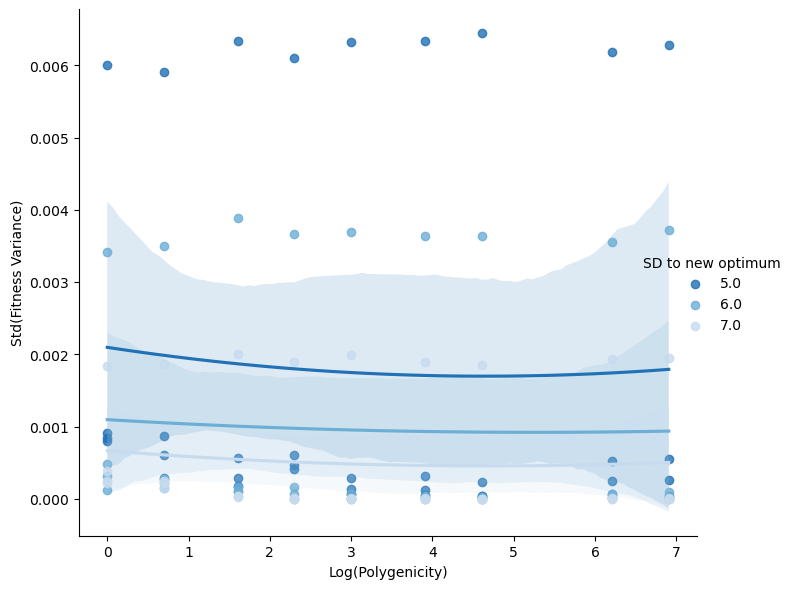

In [164]:
# Use lmplot and adjust the figure size
g = sns.lmplot(data=vfitnes_far, x='log_poly', y='vfitnes_gen0', scatter=True, order=2, hue="optima_int",
               palette='Blues_r', height=6, aspect=1.2)

# Calculate the x and y values for the line and text
x_value = np.log(30)

# Add a vertical line to the plot
#plt.axvline(x=x_value, color='grey', linestyle='--')

# Change the labels of the x and y axes
g.set_xlabels('Log(Polygenicity)')
g.set_ylabels('Std(Fitness Variance)')

g._legend.set_title("SD to new optimum")

# Add a label for the vertical line


# Uncomment to save the figure
#g.savefig("figures/varvarfit_overpoly.pdf", format='svg', bbox_inches='tight')
#g.savefig("figures/varvarfit_overpoly.png", format='png', bbox_inches='tight', dpi=300)

plt.show()


In [ ]:
# Use lmplot and adjust the figure size
g = sns.lmplot(data=vfitnes, x='log_poly', y='vfitnes_gen0', scatter=True, order=2, hue="optima_int",
               palette='Blues_r', height=6, aspect=1.2)

# Calculate the x and y values for the line and text
x_value = np.log(30)

# Add a vertical line to the plot
plt.axvline(x=x_value, color='grey', linestyle='--')

# Change the labels of the x and y axes
g.set_xlabels('Log(Polygenicity)')
g.set_ylabels('Std(Fitness Variance)')

g._legend.set_title("SD to new optimum")

# Add a label for the vertical line
g.ax.text(x=x_value - 0.2,  # Adjust this value as needed to move the text to the left
         y=0.03, 
         s='log(30)', 
         horizontalalignment='right', 
         verticalalignment='top', 
         color='grey', 
         fontsize=16)

# Uncomment to save the figure
#g.savefig("figures/varvarfit_overpoly.pdf", format='svg', bbox_inches='tight')
#g.savefig("figures/varvarfit_overpoly.png", format='png', bbox_inches='tight', dpi=300)

plt.show()


In [167]:
vfitnes1 = vfitnes[vfitnes['h2']==0.9]

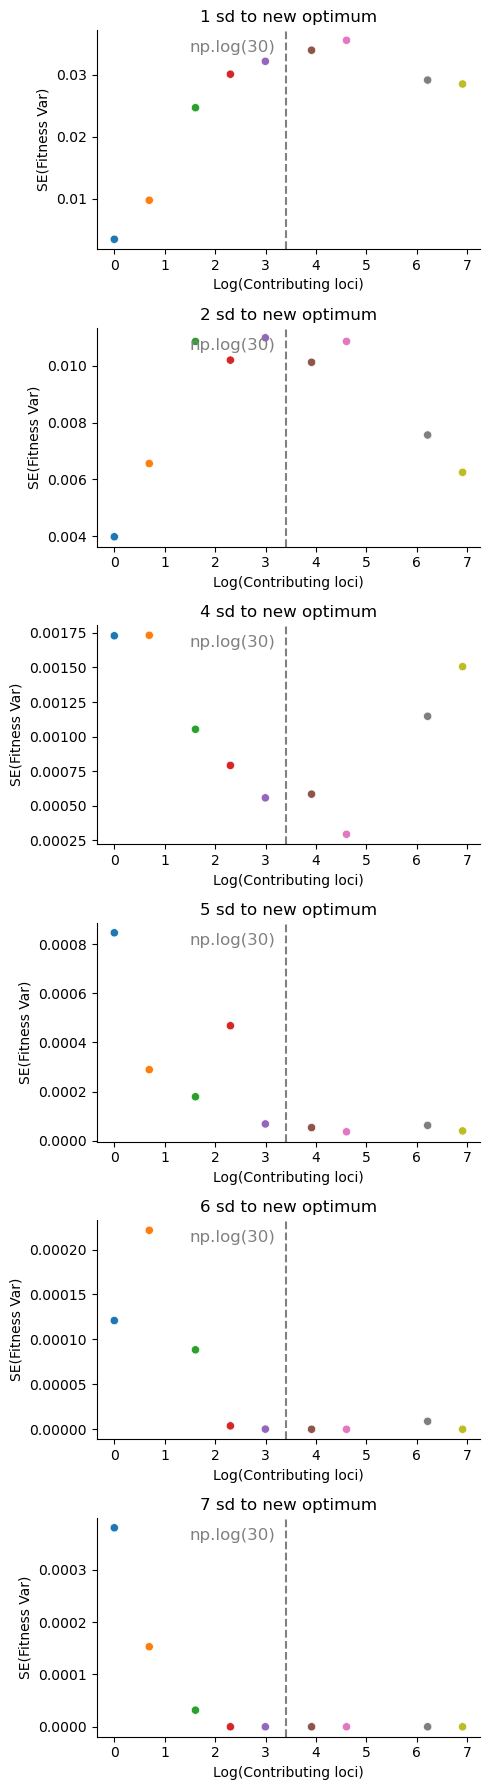

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming 'vfitnes' is your DataFrame and it contains an 'optima' column with multiple unique values
optima_values = ['optima1', 'optima2', 'optima4', 'optima5', 'optima6', 'optima7']

# Set up the subplots
n_optima = len(optima_values)
fig, axs = plt.subplots(n_optima, 1, figsize=(5, 3 * n_optima))  # Adjusting the subplot size

# Track handles and labels for the legend
handles, labels = None, None

for ax, optima in zip(axs, optima_values):
    # Filter the data for the current 'optima'
    vfitnes_h27 = vfitnes1[vfitnes1['optima'] == optima]
    
    # Create the scatter plot for the current 'optima'
    scatter = sns.scatterplot(data=vfitnes_h27, x='log_poly', y='vfitnes_gen0', hue='poly_str', ax=ax, legend=False)
    
    # Capture handles and labels for the first subplot to use for a figure-wide legend
    if handles is None and labels is None:
        handles, labels = scatter.get_legend_handles_labels()
    
    # Add a vertical line
    x_value = np.log(30)
    y_value = vfitnes_h27['vfitnes_gen0'].max()
    ax.axvline(x=x_value, color='grey', linestyle='--')
    
    # Change x and y axis labels and set title to indicate the 'optima'
    ax.set_xlabel('Log(Contributing loci)')
    ax.set_ylabel('SE(Fitness Var)')
    optima = optima.replace('optima', '')
    ax.set_title(f'{optima} sd to new optimum')
    
    # Add a label for the vertical line
    ax.text(x=x_value - 0.2, y=y_value, s='np.log(30)', horizontalalignment='right', verticalalignment='top', color='grey', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Place a single legend outside the subplots
#fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.25, 0.5), title='Poly String')
#plt.savefig("log_polyvs_sefitnessvar_sim.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("log_polyvs_sefitnessvar_sim.png", format='png', bbox_inches='tight')

plt.tight_layout()
plt.show()


In [214]:
len(['2','5','10','20','50','100','500','1000'])

8